# Preparation
Import the modules:

In [1]:
import time
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_num(file):
    return int(file.readline())


def read_matrix(file, number_of_objects):
    return np.array([[int(num) for num in file.readline().split()]
                     for _ in range(number_of_objects)], dtype='float64')

# Normalization

In [3]:
def dataset_minmax(ds):
    minmax = list()
    for i in range(len(ds[0])):
        if i == len(ds[0]) - 1:
            continue
        value_min = ds[:, i].min()
        value_max = ds[:, i].max()
        minmax.append((value_min, value_max))
    return minmax


def normalize(ds, minmax):
    for row in ds:
        for i in range(len(row)):
            if i == len(row) - 1:
                continue
            difference = minmax[i][1] - minmax[i][0]
            row[i] = 0 if 0 == difference else (row[i] - minmax[i][0]) / difference  # (x - min) / (max - min)
    return ds

In [4]:
start_time = time.time()
filename = 'datasets/1.txt'
f = open(filename)

# Number of features in objects excluding dependent variable.
number_of_features = read_num(f)

# Number of objects in a training set.
number_of_trainings = read_num(f)

# Description of training set objects.
trainings_description = read_matrix(f, number_of_trainings)
normalize_trainings = normalize(trainings_description, dataset_minmax(trainings_description))
trainings_x = normalize_trainings[:, :-1]
trainings_y = normalize_trainings[:, -1]

# Number of objects in the test set.
number_of_tests = read_num(f)

# Description of the test set object.
tests_description = read_matrix(f, number_of_tests)
normalize_tests = normalize(tests_description, dataset_minmax(tests_description))
test_x = tests_description[:, :-1]
test_y = tests_description[:, -1]

f.close()

normalize_trainings

array([[ 9.84951835e-01,  3.80368098e-01,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00, -6.21966200e+06],
       [ 9.32624230e-01,  3.06748466e-01,  0.00000000e+00, ...,
         0.00000000e+00,  9.95236372e-01, -4.47274000e+06],
       [ 9.97813980e-01,  6.01226994e-01,  0.00000000e+00, ...,
         0.00000000e+00,  9.43801254e-01, -4.25029200e+06],
       ...,
       [ 1.01555942e-01,  3.00613497e-01,  0.00000000e+00, ...,
         0.00000000e+00,  1.05704293e-01,  3.06088720e+07],
       [ 2.55061820e-01,  6.74846626e-01,  0.00000000e+00, ...,
         0.00000000e+00,  1.03111433e-02,  3.18853990e+07],
       [ 9.06476920e-02,  5.39877301e-01,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  3.43536600e+07]])

In [5]:
def smape(y_actual, y_predicted):
    return np.mean(np.abs(y_actual - y_predicted) / (np.abs(y_actual) + np.abs(y_predicted)))

In [6]:
def regularization_pseudoinverse(_lambda):
    if _lambda == 0:
        res = np.linalg.pinv(trainings_x) @ trainings_y
    else:
        res = np.linalg.inv(trainings_x.T @ trainings_x + _lambda * np.eye(number_of_features)) \
              @ trainings_x.T @ trainings_y
    return res, smape(test_y, res @ test_x.T), smape(trainings_y, res @ trainings_x.T)

In [7]:
def regularization_stochastic_gradient_descent(reps, _lambda):
    smape_tests = []
    smape_trains = []
    gradient = 0
    omega = 0.9
    weights = np.random.uniform(-1 / (2 * number_of_features),
                                1 / (2 * number_of_features),
                                number_of_features)
    for num in map(lambda k: 1 / k, range(1, reps + 1)):
        i = random.randint(0, number_of_features - 1)
        gradient = 2 * ((1 - omega) * ((weights @ trainings_x[i]) - trainings_y[i])
                        * trainings_x[i] + _lambda * weights) + omega * gradient
        weights -= num * gradient
        smape_tests.append(smape(test_y, weights @ test_x.T))
        smape_trains.append(smape(trainings_y, weights @ trainings_x.T))
    return weights, smape_tests, smape_trains

# Hyperparameter setting

In [8]:
def find_best(algo):
    y_predicted = algo(0)[0] @ test_x.T
    min_error = smape(test_y, y_predicted)
    best_res = 0
    # start, end, qty
    for res in np.linspace(0, 2, 500):
        y_predicted = algo(res)[0] @ test_x.T
        score = smape(test_y, y_predicted)
        if score < min_error:
            best_res = res
            min_error = score
    print(best_res, " (with score ", min_error, ")")
    return best_res

# Analysis

In [ ]:
print("Best hyperparameters: ")
print("1. Least squares ")
find_best(regularization_pseudoinverse)
print("2. Stochastic gradient ")
find_best(lambda x: regularization_stochastic_gradient_descent(2000, x))

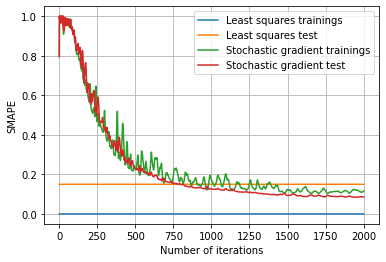

Total working time: 88.94250249862671 seconds.


In [20]:
def graph(p_best_lambda, g_best_lambda):
    w, smape_tests, smape_trains = regularization_stochastic_gradient_descent(2000, g_best_lambda)
    w, smape_test, smape_train = regularization_pseudoinverse(p_best_lambda)
    x = np.arange(1, len(smape_tests) + 1)
    plt.plot(x, np.repeat(smape_train, len(x)), label='Least squares trainings')
    plt.plot(x, np.repeat(smape_test, len(x)), label='Least squares test')
    plt.plot(x, smape_trains, label='Stochastic gradient trainings')
    plt.plot(x, smape_tests, label='Stochastic gradient test')
    plt.xlabel('Number of iterations')
    plt.ylabel('SMAPE')
    plt.legend()
    plt.grid(True)
    plt.show()


graph(0.3807615230460922, 0.05016722408026756)

print("Total working time: %s seconds." % (time.time() - start_time))